In [1]:
pip install xlrd

In [2]:
import csv
import pandas as pd
import json
import sqlite3
from sqlalchemy import create_engine, inspect
import os
import requests
from bs4 import BeautifulSoup
import urllib.request
from urllib.error import URLError, HTTPError

# Parte 1 - Programar em Python com arquivos, sets e dicionários

1. Crie uma base de dados em formato de arquivo .csv, entitulada base.csv, que contenha os campos placa, marca, modelo, ano, cor e classificação, podendo ser novo, semi-novo e usado.

In [3]:
# Dados para o csv
dados = [
    {"placa": "ABC1234", "marca": "Toyota", "modelo": "Corolla", "ano": 2020, "cor": "Prata", "classificacao": "novo"},
    {"placa": "DEF5678", "marca": "Ford", "modelo": "Fiesta", "ano": 2018, "cor": "Branco", "classificacao": "semi-novo"},
    {"placa": "GHI9101", "marca": "Chevrolet", "modelo": "Onix", "ano": 2019, "cor": "Preto", "classificacao": "usado"},
    {"placa": "JKL1213", "marca": "Honda", "modelo": "Civic", "ano": 2021, "cor": "Azul", "classificacao": "novo"},
    {"placa": "MNO1415", "marca": "Hyundai", "modelo": "HB20", "ano": 2017, "cor": "Vermelho", "classificacao": "usado"}
]

arquivo_csv = 'base.csv'
campos = ["placa", "marca", "modelo", "ano", "cor", "classificacao"]

# Escrevendo os dados no arquivo CSV
with open(arquivo_csv, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=campos)
    writer.writeheader()
    for dado in dados:
        writer.writerow(dado)

print(f"O arquivo {arquivo_csv} foi criado com sucesso.")

O arquivo base.csv foi criado com sucesso.


2. Crie uma função que receba como parâmetro o nome/caminho do arquivo e retorne um dataframe pandas.

In [4]:
def ler_csv_para_df(caminho_arquivo):
    """
    Lê um arquivo .csv e retorna um dataframe pandas.
    """
    try:
        dataframe = pd.read_csv(caminho_arquivo)
        return dataframe
    except FileNotFoundError:
        print(f"Arquivo {caminho_arquivo} não encontrado.")
    except pd.errors.EmptyDataError:
        print(f"Arquivo {caminho_arquivo} está vazio.")
    except pd.errors.ParserError:
        print(f"Ocorreu um erro ao analisar o arquivo {caminho_arquivo}.")

caminho_arquivo = input("Por favor, insira o caminho do arquivo .csv: ")
df = ler_csv_para_df(caminho_arquivo)

if df is not None:
    print('\n')
    print(df)

Por favor, insira o caminho do arquivo .csv: base.csv


     placa      marca   modelo   ano       cor classificacao
0  ABC1234     Toyota  Corolla  2020     Prata          novo
1  DEF5678       Ford   Fiesta  2018    Branco     semi-novo
2  GHI9101  Chevrolet     Onix  2019     Preto         usado
3  JKL1213      Honda    Civic  2021      Azul          novo
4  MNO1415    Hyundai     HB20  2017  Vermelho         usado


3. Crie uma função que faça a busca por placa, recebendo como parâmetros de entrada o dataframe com o banco de dados e a placa do carro, e retorne um objeto do tipo .json com a seguinte estrutura:

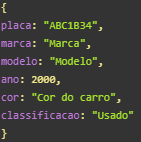

In [5]:
def busca_placa(df, placa):
    """
    Busca um carro pela placa no dataframe e retorna um objeto JSON com os detalhes do carro.
    """
    carro = df[df['placa'] == placa]
    if not carro.empty:
        carro_dict = carro.iloc[0].to_dict()
        formatted_json = (
            "{\n"
            f"placa: \"{carro_dict['placa']}\",\n"
            f"marca: \"{carro_dict['marca']}\",\n"
            f"modelo: \"{carro_dict['modelo']}\",\n"
            f"ano: {carro_dict['ano']},\n"
            f"cor: \"{carro_dict['cor']}\",\n"
            f"classificacao: \"{carro_dict['classificacao']}\"\n"
            "}"
        )
        return formatted_json
    else:
        return "{\nerror: \"Carro não encontrado\"\n}"

if __name__ == "__main__":
    placa = input("Por favor, insira a placa do carro: ")

    resultado = busca_placa(df, placa)
    print(resultado)

Por favor, insira a placa do carro: abc1234
{
error: "Carro não encontrado"
}


4. Crie uma função que faça o salvamento dos dados de busca em um arquivo .json, recebendo como parâmetros de entrada um objeto .json chamado dado e o nome do arquivo a ser salvo.

In [6]:
def salvar_json(dado, nome_arquivo):
    """
    Salva um objeto JSON em um arquivo .json.
    """
    try:
        with open(nome_arquivo, 'w') as f:
            json.dump(dado, f, indent=4)
        print(f"Dados salvos no arquivo '{nome_arquivo}' com sucesso!")
        return True
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o arquivo '{nome_arquivo}': {str(e)}")
        return False


if __name__ == "__main__":
    dado_exemplo = {
        "placa": "ABC1234",
        "marca": "Toyota",
        "modelo": "Corolla",
        "ano": 2020,
        "cor": "Preto",
        "classificacao": "Sedan"
    }

    nome_arquivo = "dados_busca.json"

    sucesso = salvar_json(dado_exemplo, nome_arquivo)

    if sucesso:
        print(f"Dados salvos com sucesso no arquivo '{nome_arquivo}'!")
    else:
        print(f"Falha ao salvar os dados no arquivo '{nome_arquivo}'.")


Dados salvos no arquivo 'dados_busca.json' com sucesso!
Dados salvos com sucesso no arquivo 'dados_busca.json'!


# Parte 2 - Consumir dados em diferentes formatos utilizando a biblioteca Pandas

1. Crie uma função que receba como parâmetros de entrada um objeto .json com a mesma estrutura apresentada na questão 1C e o dataframe do banco de dados e faça a inclusão desse registro na base de dados. O retorno da função deve ser o dataframe atualizado com o novo registro.

In [7]:
def adicionar_json_ao_df(json_obj, df):
    """
    Adiciona um registro no dataframe a partir de um objeto JSON.
    """
    try:
        # Converte o JSON em um dicionário
        carro_dict = json.loads(json_obj)

        if 'error' in carro_dict:
            print("Erro ao adicionar registro: ", carro_dict['error'])
            return df

        # Adiciona o dicionário como uma nova linha no dataframe
        df_novo_registro = pd.DataFrame([carro_dict])
        df = pd.concat([df, df_novo_registro], ignore_index=True)

        return df
    except Exception as e:
        return f"Ocorreu um erro: {str(e)}"

if __name__ == "__main__":
    caminho_arquivo = 'base.csv'
    df = ler_csv_para_df(caminho_arquivo)

    json_obj = '''{
        "placa": "XYZ9876",
        "marca": "Fiat",
        "modelo": "Uno",
        "ano": 2022,
        "cor": "Azul",
        "classificacao": "novo"
    }'''

    df_atualizado = adicionar_json_ao_df(json_obj, df)

    print(df_atualizado)

     placa      marca   modelo   ano       cor classificacao
0  ABC1234     Toyota  Corolla  2020     Prata          novo
1  DEF5678       Ford   Fiesta  2018    Branco     semi-novo
2  GHI9101  Chevrolet     Onix  2019     Preto         usado
3  JKL1213      Honda    Civic  2021      Azul          novo
4  MNO1415    Hyundai     HB20  2017  Vermelho         usado
5  XYZ9876       Fiat      Uno  2022      Azul          novo


2. Crie uma função que receba como parâmetros de entrada o caminho/nome de um arquivo .csv e o dataframe do banco de dados e faça a inclusão desse registro na base de dados. O retorno da função deve ser o dataframe atualizado com o novo registro e a estrutura do arquivo de entrada deve ser a mesma apresentada na questão 1A.

In [8]:
import pandas as pd
import csv

def adicionar_csv_ao_df(caminho_arquivo_csv, df):
    """
    Adiciona os dados de um arquivo CSV ao dataframe existente.
    """
    try:
        novo_df = pd.read_csv(caminho_arquivo_csv)

        # Concatenação dos dfs
        df_atualizado = pd.concat([df, novo_df], ignore_index=True)

        return df_atualizado
    except Exception as e:
        return f"Ocorreu um erro: {str(e)}"

if __name__ == "__main__":
    caminho_arquivo = 'base.csv'
    df = ler_csv_para_df(caminho_arquivo)

    # Dados do novo csv que será incluído na base já existente
    caminho_arquivo_csv = 'novos_dados.csv'
    dados = [
        {"placa": "XYZ9876", "marca": "Fiat", "modelo": "Uno", "ano": 2022, "cor": "Azul", "classificacao": "novo"}
    ]
    campos = ["placa", "marca", "modelo", "ano", "cor", "classificacao"]

    # Criação do csv novo
    with open(caminho_arquivo_csv, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=campos)
        writer.writeheader()
        for dado in dados:
            writer.writerow(dado)

    print(f"O arquivo {caminho_arquivo_csv} foi criado com sucesso.")

    df_atualizado = adicionar_csv_ao_df(caminho_arquivo_csv, df)
    print('\n')
    print(df_atualizado)

O arquivo novos_dados.csv foi criado com sucesso.


     placa      marca   modelo   ano       cor classificacao
0  ABC1234     Toyota  Corolla  2020     Prata          novo
1  DEF5678       Ford   Fiesta  2018    Branco     semi-novo
2  GHI9101  Chevrolet     Onix  2019     Preto         usado
3  JKL1213      Honda    Civic  2021      Azul          novo
4  MNO1415    Hyundai     HB20  2017  Vermelho         usado
5  XYZ9876       Fiat      Uno  2022      Azul          novo


3. Crie uma função que receba como parâmetros de entrada o caminho/nome de um arquivo .xls e o dataframe do banco de dados e faça a inclusão desse registro na base de dados. O retorno da função deve ser o dataframe atualizado com o novo registro e a estrutura do arquivo de entrada deve ser a mesma apresentada na questão 1A.

In [9]:
import pandas as pd

def adicionar_xlsx_ao_df(caminho_arquivo_xlsx, df):
    """
    Adiciona os dados de um arquivo XLS ao dataframe existente.
    """
    try:
        # Lendo o xls
        novo_df = pd.read_excel(caminho_arquivo_xlsx)

        # Concatenando os dfs
        df_atualizado = pd.concat([df, novo_df], ignore_index=True)
        return df_atualizado

    except FileNotFoundError:
        print(f"Arquivo {caminho_arquivo_xlsx} não encontrado.")
        return df

if __name__ == "__main__":
    caminho_arquivo = 'base.csv'
    df = ler_csv_para_df(caminho_arquivo)

    # Dados do xlsx
    caminho_arquivo_xlsx = 'novos_dados.xlsx'
    dados = pd.DataFrame([
        {"placa": "XYZ9876", "marca": "Fiat", "modelo": "Uno", "ano": 2022, "cor": "Azul", "classificacao": "novo"}
    ])

    dados.to_excel(caminho_arquivo_xlsx, index=False)
    print(f"O arquivo {caminho_arquivo_xlsx} foi criado com sucesso.")

    df_atualizado = adicionar_xlsx_ao_df(caminho_arquivo_xlsx, df)
    print('\n')
    print(df_atualizado)

O arquivo novos_dados.xlsx foi criado com sucesso.


     placa      marca   modelo   ano       cor classificacao
0  ABC1234     Toyota  Corolla  2020     Prata          novo
1  DEF5678       Ford   Fiesta  2018    Branco     semi-novo
2  GHI9101  Chevrolet     Onix  2019     Preto         usado
3  JKL1213      Honda    Civic  2021      Azul          novo
4  MNO1415    Hyundai     HB20  2017  Vermelho         usado
5  XYZ9876       Fiat      Uno  2022      Azul          novo


4. Crie uma função que faça a busca por todos os carros de uma dada classificação e faça o salvamento em um arquivo do tipo .xls. A função deve receber como parâmetro de entrada o tipo de classificação, podendo ser novo, semi-novo ou usado.

In [10]:
def salvar_classificacao_em_xlsx(df_atualizado):
    """
    Filtra os carros pelo tipo de classificação fornecido pelo usuário e salva os dados em um arquivo .xlsx.
    """
    try:
        # Solicitar a classificação desejada ao usuário
        classificacao = input("Por favor, insira a classificação desejada (novo, semi-novo ou usado): ").strip().lower()

        # Verificar se a classificação fornecida é válida
        if classificacao not in ['novo', 'semi-novo', 'usado']:
            raise ValueError("Classificação inválida. Por favor, insira 'novo', 'semi-novo' ou 'usado'.")

        # Filtra os dados pelo tipo de classificação
        carros_filtrados = df_atualizado[df_atualizado['classificacao'] == classificacao]

        # Nome do arquivo xlsx
        arquivo_xlsx = f'carros_{classificacao}.xlsx'

        # Salva os dados filtrados em um arquivo .xlsx
        carros_filtrados.to_excel(arquivo_xlsx, index=False)

        return f"O arquivo {arquivo_xlsx} foi criado com sucesso."

    except Exception as e:
        return f"Ocorreu um erro: {str(e)}"


if __name__ == "__main__":
    caminho_arquivo = 'base.csv'
    df = ler_csv_para_df(caminho_arquivo)

    mensagem = salvar_classificacao_em_xlsx(df)
    print('\n')
    print(mensagem)


Por favor, insira a classificação desejada (novo, semi-novo ou usado): semi-novo


O arquivo carros_semi-novo.xlsx foi criado com sucesso.


# Parte 3 - Manipular dados tabulares provenientes de planilhas e banco de dados utilizando a biblioteca Pandas

1. Modifique a função desenvolvida na questão 1B de forma que ela detecte o tipo de arquivo que foi informado e faça o carregamento dos dados em um dataframe pandas

In [11]:
def ler_arquivo_e_adicionar_df(caminho_arquivo, df):
    """
    Detecta o tipo de arquivo (.json, .csv, .xlsx) e adiciona os dados ao dataframe existente.
    """
    try:
        # Identifica a extensão do arquivo
        if caminho_arquivo.endswith('.json'):
            with open(caminho_arquivo, 'r', encoding='utf-8') as file:
                json_data = json.load(file)
            novo_df = pd.DataFrame(json_data)

        elif caminho_arquivo.endswith('.csv'):
            novo_df = pd.read_csv(caminho_arquivo)

        elif caminho_arquivo.endswith('.xlsx'):
            novo_df = pd.read_excel(caminho_arquivo)
        else:
            raise ValueError("Extensão de arquivo não suportada. Por favor, insira um arquivo .json, .csv ou .xlsx.")

        # Concatena os dfs
        df_atualizado = pd.concat([df, novo_df], ignore_index=True)

        return df_atualizado

    except FileNotFoundError:
        print(f"Arquivo {caminho_arquivo} não encontrado.")
        return df
    except pd.errors.EmptyDataError:
        print(f"Arquivo {caminho_arquivo} está vazio.")
        return df
    except pd.errors.ParserError:
        print(f"Ocorreu um erro ao analisar o arquivo {caminho_arquivo}.")
        return df
    except ValueError as ve:
        print(f"Erro: {str(ve)}")
        return df

if __name__ == "__main__":
    caminho_arquivo = input("Por favor, insira o caminho do arquivo (.json, .csv, .xlsx): ").strip()


    if caminho_arquivo:
        caminho_base_csv = 'base.csv'
        df = ler_csv_para_df(caminho_base_csv)

        df_atualizado = ler_arquivo_e_adicionar_df(caminho_arquivo, df)

        print('\n')
        print(df_atualizado)


Por favor, insira o caminho do arquivo (.json, .csv, .xlsx): xlsx
Erro: Extensão de arquivo não suportada. Por favor, insira um arquivo .json, .csv ou .xlsx.


     placa      marca   modelo   ano       cor classificacao
0  ABC1234     Toyota  Corolla  2020     Prata          novo
1  DEF5678       Ford   Fiesta  2018    Branco     semi-novo
2  GHI9101  Chevrolet     Onix  2019     Preto         usado
3  JKL1213      Honda    Civic  2021      Azul          novo
4  MNO1415    Hyundai     HB20  2017  Vermelho         usado


2. Modifique a função criada na questão 1B de forma que ela crie uma base SQL, utilizando a biblioteca sqlite3, que armazene a base de dados a partir de um arquivo .csv como o proposto na questão 1A. O retorno da função deve ser um banco de dados SQL.

In [12]:
def criar_banco_sqlite(caminho_arquivo_csv, nome_banco='database_carros.db'):
    """
    Cria um banco de dados SQLite a partir de um arquivo .csv.
    Retorna a conexão com o banco de dados.
    """
    try:
        # Conecta ao banco de dados SQLite
        conn = sqlite3.connect(nome_banco)
        cursor = conn.cursor()

        # Cria a tabela no banco de dados
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS CARROS(
                id_carro INTEGER PRIMARY KEY,
                placa VARCHAR(50),
                marca VARCHAR(50),
                modelo VARCHAR(50),
                ano VARCHAR(4),
                cor VARCHAR(50),
                classificacao VARCHAR(50)
            )
        ''')

        # Lê o arquivo CSV e inserir os dados na tabela
        with open(caminho_arquivo_csv, mode='r', newline='') as file:
            reader = csv.DictReader(file)
            dados = [(row['placa'], row['marca'], row['modelo'], row['ano'], row['cor'], row['classificacao']) for row in reader]

        cursor.executemany('''
            INSERT OR REPLACE INTO CARROS (placa, marca, modelo, ano, cor, classificacao)
            VALUES (?, ?, ?, ?, ?, ?)
        ''', dados)

        conn.commit()

        print(f"\nBanco de dados {nome_banco} criado e populado com sucesso!")

        return conn

    except sqlite3.Error as e:
        print(f"Erro ao criar e popular o banco de dados SQLite: {e}")
        return None
    except FileNotFoundError:
        print(f"Arquivo {caminho_arquivo_csv} não encontrado.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {str(e)}")
        return None

if __name__ == "__main__":
    caminho_arquivo_csv = input("Por favor, insira o caminho do arquivo .csv (base.csv): ").strip().lower()

    if caminho_arquivo_csv:
        conn = criar_banco_sqlite(caminho_arquivo_csv)

        if conn:
            cursor = conn.cursor()
            cursor.execute("SELECT * FROM CARROS")
            rows = cursor.fetchall()
            print('\n')
            for row in rows:
                print(row)

            conn.close()


Por favor, insira o caminho do arquivo .csv (base.csv): base.csv

Banco de dados database_carros.db criado e populado com sucesso!


(1, 'ABC1234', 'Toyota', 'Corolla', '2020', 'Prata', 'novo')
(2, 'DEF5678', 'Ford', 'Fiesta', '2018', 'Branco', 'semi-novo')
(3, 'GHI9101', 'Chevrolet', 'Onix', '2019', 'Preto', 'usado')
(4, 'JKL1213', 'Honda', 'Civic', '2021', 'Azul', 'novo')
(5, 'MNO1415', 'Hyundai', 'HB20', '2017', 'Vermelho', 'usado')


3. Crie uma função que receba um banco de dados SQL, gere e retorne um dataframe pandas, utilizando a biblioteca sqlalchemy.

In [13]:
def db_to_dataframe(conn_str, tabela):
    """
    Conecta ao banco de dados SQL especificado por conn_str, verifica a existência da tabela,
    e retorna um dataframe pandas com os resultados.
    """
    # Cria uma conexão usando sqlalchemy
    engine = create_engine(conn_str)
    inspector = inspect(engine)

    # Verifica se a tabela existe no banco de dados
    if tabela not in inspector.get_table_names():
        print(f"A tabela {tabela} não existe no banco de dados.")
        return False

    # Consulta todos os dados da tabela especificada
    query = f"SELECT * FROM {tabela}"
    df = pd.read_sql_query(query, engine)

    # Verifica se o DataFrame está vazio
    if df.empty:
        print(f"A tabela {tabela} está vazia.")
        return False

    return df

if __name__ == "__main__":

    # String de conexão com o banco de dados SQLite
    conn_str = 'sqlite:///database_carros.db'

    tabela = 'CARROS'

    df = db_to_dataframe(conn_str, tabela)

    if isinstance(df, pd.DataFrame):
        print(df.head())
    else:
        print("Falha ao carregar os dados da tabela.")

   id_carro    placa      marca   modelo   ano       cor classificacao
0         1  ABC1234     Toyota  Corolla  2020     Prata          novo
1         2  DEF5678       Ford   Fiesta  2018    Branco     semi-novo
2         3  GHI9101  Chevrolet     Onix  2019     Preto         usado
3         4  JKL1213      Honda    Civic  2021      Azul          novo
4         5  MNO1415    Hyundai     HB20  2017  Vermelho         usado


4. Crie uma função que crie uma base de dados SQL a partir de um dataframe pandas, utilizando a biblioteca sqlalchemy. Os parâmetros de entrada devem ser o dataframe com a base de dados e o nome da base de dados SQL que será gerada. A saída deve ser uma base de dados SQL.

In [14]:
def criar_banco_sql(dataframe, nome_banco):
    """
    Cria um banco de dados SQL a partir de um DataFrame pandas.
    """
    try:
        engine = create_engine(f'sqlite:///{nome_banco}')

        dataframe.to_sql(name='CARROS_SQLALCHEMY', con=engine, index=False, if_exists='replace')

        print(f"Banco de dados {nome_banco} criado e populado com sucesso!")

        return engine

    except Exception as e:
        print(f"Ocorreu um erro ao criar e popular o banco de dados: {str(e)}")
        return None

if __name__ == "__main__":

    caminho_base_csv = 'base.csv'
    df = ler_csv_para_df(caminho_base_csv)

    nome_banco = 'database_sqlalchemy.db'

    engine = criar_banco_sql(df, nome_banco)

    if engine:
        consulta = pd.read_sql_query('SELECT * FROM CARROS_SQLALCHEMY', engine)
        print("\nConsulta ao banco de dados:")
        print(consulta)

Banco de dados database_sqlalchemy.db criado e populado com sucesso!

Consulta ao banco de dados:
     placa      marca   modelo   ano       cor classificacao
0  ABC1234     Toyota  Corolla  2020     Prata          novo
1  DEF5678       Ford   Fiesta  2018    Branco     semi-novo
2  GHI9101  Chevrolet     Onix  2019     Preto         usado
3  JKL1213      Honda    Civic  2021      Azul          novo
4  MNO1415    Hyundai     HB20  2017  Vermelho         usado


# Parte 4 - Encontrar e tratar bugs (erros) em Python

1. Faça uma modificação na função desenvolvida na questão 1D, de forma que seja tratado erros na informação do caminho escolhido para o salvamento do arquivo. Caso o caminho esteja correto, a função salva o arquivo e retorna True. Em caso de erro, não salvar o arquivo e informar ao usuário que o arquivo não foi salvo e qual o motivo de não poder executar a operação e retornar False.

In [15]:
def salvar_json(dado, nome_arquivo):
    """
    Salva um objeto JSON em um arquivo .json.
    """
    try:
        # Verifica se o diretório de destino existe
        diretorio = os.path.dirname(nome_arquivo)
        if diretorio:
            os.makedirs(diretorio, exist_ok=True)

        # Tenta salvar o arquivo JSON
        with open(nome_arquivo, 'w') as f:
            json.dump(dado, f, indent=4)
        print(f"Dados salvos no arquivo '{nome_arquivo}' com sucesso!")
        return True

    except FileNotFoundError:
        print(f"Erro ao salvar o arquivo '{nome_arquivo}': Diretório não encontrado.")
        return False

    except IsADirectoryError:
        print(f"Erro ao salvar o arquivo '{nome_arquivo}': O caminho especificado é um diretório, não um arquivo.")
        return False

    except IOError as e:
        print(f"Erro ao salvar o arquivo '{nome_arquivo}': {str(e)}")
        return False

    except Exception as e:
        print(f"Erro inesperado ao salvar o arquivo '{nome_arquivo}': {str(e)}")
        return False


if __name__ == "__main__":
    dado_exemplo = {
        "placa": "ABC1234",
        "marca": "Toyota",
        "modelo": "Corolla",
        "ano": 2020,
        "cor": "Preto",
        "classificacao": "Sedan"
    }

    # Solicita ao usuário que insira o caminho completo onde deseja salvar o arquivo JSON
    nome_arquivo = input("Por favor, insira o caminho completo onde deseja salvar o arquivo JSON (dados_busca.json): ").strip()

    sucesso = salvar_json(dado_exemplo, nome_arquivo)

    if sucesso:
        print(f"Dados salvos com sucesso no arquivo '{nome_arquivo}'!")
    else:
        print(f"Falha ao salvar os dados no arquivo '{nome_arquivo}'.")


Por favor, insira o caminho completo onde deseja salvar o arquivo JSON (dados_busca.json): dados_busca.json
Dados salvos no arquivo 'dados_busca.json' com sucesso!
Dados salvos com sucesso no arquivo 'dados_busca.json'!


2. Faça uma modificação na função da questão 2C que permita avaliar se o carregamento do arquivo .xls foi realizado corretamente. Em caso positivo, a função deve retornar o dataframe atualizado e, em caso negativo, deve retornar False.

In [16]:
def adicionar_xlsx_ao_dataframe(caminho_arquivo_xlsx, df):
    """
    Adiciona os dados de um arquivo XLS ao dataframe existente.
    Retorna o dataframe atualizado se o arquivo for lido corretamente, ou False caso contrário.
    """
    try:
        # Lendo o xlsx
        novo_df = pd.read_excel(caminho_arquivo_xlsx)

        # Verifica se o dataframe lido está vazio
        if novo_df.empty:
            print(f"Arquivo {caminho_arquivo_xlsx} está vazio.")
            return False

        # Concatenando os dfs
        df_atualizado = pd.concat([df, novo_df], ignore_index=True)
        return df_atualizado

    except FileNotFoundError:
        print(f"Arquivo {caminho_arquivo_xlsx} não encontrado.")
        return False
    except pd.errors.EmptyDataError:
        print(f"Arquivo {caminho_arquivo_xlsx} está vazio.")
        return False
    except pd.errors.ParserError:
        print(f"Ocorreu um erro ao analisar o arquivo {caminho_arquivo_xlsx}.")
        return False

if __name__ == "__main__":
    caminho_arquivo = 'base.csv'
    df = pd.read_csv(caminho_arquivo)

    # Criando um arquivo XLSX com dados adicionais
    caminho_arquivo_xlsx = 'novos_dados.xlsx'
    dados = pd.DataFrame([
        {"placa": "XYZ9876", "marca": "Fiat", "modelo": "Uno", "ano": 2022, "cor": "Azul", "classificacao": "novo"}
    ])
    dados.to_excel(caminho_arquivo_xlsx, index=False)
    print(f"O arquivo {caminho_arquivo_xlsx} foi criado com sucesso.")

    # Chamando a função para adicionar os dados do XLSX ao dataframe
    df_atualizado = adicionar_xlsx_ao_dataframe(caminho_arquivo_xlsx, df)

    if isinstance(df_atualizado, pd.DataFrame):
        print('\nDataframe Atualizado:')
        print(df_atualizado)
    else:
        print('\nFalha ao adicionar dados do XLSX.')

O arquivo novos_dados.xlsx foi criado com sucesso.

Dataframe Atualizado:
     placa      marca   modelo   ano       cor classificacao
0  ABC1234     Toyota  Corolla  2020     Prata          novo
1  DEF5678       Ford   Fiesta  2018    Branco     semi-novo
2  GHI9101  Chevrolet     Onix  2019     Preto         usado
3  JKL1213      Honda    Civic  2021      Azul          novo
4  MNO1415    Hyundai     HB20  2017  Vermelho         usado
5  XYZ9876       Fiat      Uno  2022      Azul          novo


3. Modifique a questão 3C de forma que seja possível garantir que a base de dados SQL foi corretamente carregada. Em caso positivo, o retorno deve ser a base de dados e, em caso negativo, deverá ser retornado o valor False.

In [17]:
def db_to_dataframe(conn_str, tabela):
    """
    Conecta ao banco de dados SQL especificado por conn_str, executa uma consulta SQL na tabela especificada
    e retorna um dataframe pandas com os resultados.
    """
    try:
        # Cria uma conexão usando sqlalchemy
        engine = create_engine(conn_str)

        # Consulta todos os dados da tabela especificada
        query = f"SELECT * FROM {tabela}"
        df = pd.read_sql_query(query, engine)

        return df

    except Exception as e:
        print(f"Ocorreu um erro ao conectar e consultar o banco de dados: {str(e)}")
        return False

if __name__ == "__main__":

    conn_str = 'sqlite:///database_carros.db'

    tabela = 'CARROS'

    df = db_to_dataframe(conn_str, tabela)

    if isinstance(df, pd.DataFrame):
        print(df.head())
    else:
        print("Falha ao carregar os dados da tabela.")


   id_carro    placa      marca   modelo   ano       cor classificacao
0         1  ABC1234     Toyota  Corolla  2020     Prata          novo
1         2  DEF5678       Ford   Fiesta  2018    Branco     semi-novo
2         3  GHI9101  Chevrolet     Onix  2019     Preto         usado
3         4  JKL1213      Honda    Civic  2021      Azul          novo
4         5  MNO1415    Hyundai     HB20  2017  Vermelho         usado


# Parte 5 - Realizar web scraping utilizando expressões regulares e BeautifulSoup

1. Faça a requisição de um site de () utilizando o biblioteca request e apresente o conteúdo de forma ordenada, utilizando a biblioteca BeautifulSoup.

In [20]:
# Faz a requisição HTTP para o site
url = 'https://g1.globo.com/'
response = requests.get(url)

# Verifica se a requisição foi bem-sucedida
if response.status_code == 200:
    # Faz o parsing do conteúdo HTML
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extrai e apresenta o conteúdo de forma ordenada
    print("Conteúdo HTML formatado da Página:")
    print(soup.prettify())
else:
    print(f"Falha ao acessar o site. Status code: {response.status_code}")

Conteúdo HTML formatado da Página:
<!DOCTYPE HTML>
<html class="" lang="pt-br">
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge,chrome=1" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <script id="CDA_AAS" type="text/javascript">
   window.cdaaas = window.cdaaas || {};
  window.cdaaas.SETTINGS = window.cdaaas.SETTINGS || {};
  window.cdaaas.PAGE_ANALYTICS_DATA = {"channel":"desktop","contentId":"ba3c5a72-7ed9-482e-be26-ee3d81c97bce","contentType":"home","serviceWorker":true};
  window.cdaaas.helpers = window.cdaaas.helpers || {};
  window.cdaaas.internals = {};
  window.HorizonClient = new Promise((resolve, reject) => { 
    window.cdaaas.internals.resolveHorizonPromise = resolve; 
    window.cdaaas.internals.rejectHorizonPromise = reject; 
  });

  window.HorizonHelpers = {
    unloadCallbacks: [],
  };

  window.cdaaas.featureFlags = [];
  window.cdaaas.hasFF = (ff) => window.cdaaas.featureFlags.includes(ff);

  win

2. Utilizando a função find, imprima o cabeçalho da página (head)

In [21]:
url = 'https://g1.globo.com/'
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    # Encontra o elemento <head>
    head = soup.find('head')

    # Verifica se o elemento <head> foi encontrado e imprime seu conteúdo formatado
    if head:
        print("Cabeçalho da Página (head):")
        print('\n')
        print(head.prettify())
    else:
        print("Elemento <head> não encontrado.")
else:
    print(f"Falha ao acessar o site. Status code: {response.status_code}")

Cabeçalho da Página (head):


<head>
 <meta charset="utf-8"/>
 <meta content="ie=edge,chrome=1" http-equiv="x-ua-compatible"/>
 <meta content="width=device-width, initial-scale=1" name="viewport"/>
 <script id="CDA_AAS" type="text/javascript">
  window.cdaaas = window.cdaaas || {};
  window.cdaaas.SETTINGS = window.cdaaas.SETTINGS || {};
  window.cdaaas.PAGE_ANALYTICS_DATA = {"channel":"desktop","contentId":"ba3c5a72-7ed9-482e-be26-ee3d81c97bce","contentType":"home","serviceWorker":true};
  window.cdaaas.helpers = window.cdaaas.helpers || {};
  window.cdaaas.internals = {};
  window.HorizonClient = new Promise((resolve, reject) => { 
    window.cdaaas.internals.resolveHorizonPromise = resolve; 
    window.cdaaas.internals.rejectHorizonPromise = reject; 
  });

  window.HorizonHelpers = {
    unloadCallbacks: [],
  };

  window.cdaaas.featureFlags = [];
  window.cdaaas.hasFF = (ff) => window.cdaaas.featureFlags.includes(ff);

  window.glbDebug = window.cdaaas.debugger = {
    firstTick:

3. Crie uma função que receba uma url, faça a busca por algum elemento que você deseje (ex.: título da página), passando-o como parâmetro da função, e retorne o valor encontrado

In [22]:
def buscar_tag(url, tag):
    """
    Faz uma requisição HTTP para a URL fornecida, busca a tag especificada e retorna o valor encontrado.
    """
    try:
        response = requests.get(url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            elemento = soup.find(tag)

            if elemento:
                return elemento.get_text(strip=True)
            else:
                return f"Tag <{tag}> não encontrada na página."

        else:
            return f"Falha ao acessar o site. Status code: {response.status_code}"

    except Exception as e:
        return f"Ocorreu um erro: {str(e)}"


if __name__ == "__main__":
    url = 'https://g1.globo.com/'
    tag = 'title'

    resultado = buscar_tag(url, tag)
    print(resultado)

g1 - O portal de notícias da Globo


4. Modifique a função desenvolvida de forma que, caso não seja encontrado o elemento desejado, seja exibida uma mensagem de erro e retornado o valor False. Para isso, utilize as funções controle de exceção da biblioteca urllib.error.

In [23]:
def buscar_tag(url, tag):
    """
    Faz uma requisição HTTP para a URL fornecida, busca a tag especificada e retorna o valor encontrado.
    Se a tag não for encontrada, exibe uma mensagem de erro e retorna False.
    """
    try:
        response = urllib.request.urlopen(url)
        if response.status == 200:
            soup = BeautifulSoup(response.read(), 'html.parser')
            elemento = soup.find(tag)

            # Verifica se a tag foi encontrada e retorna seu conteúdo
            if elemento:
                return elemento.get_text(strip=True)
            else:
                return f"Tag <{tag}> não encontrada na página."

        else:
            return f"Falha ao acessar o site. Status code: {response.status}"

    except HTTPError as e:
        return f"Falha ao acessar o site. HTTPError: {e.code}"
    except URLError as e:
        return f"Falha ao acessar o site. URLError: {e.reason}"
    except Exception as e:
        return f"Ocorreu um erro: {str(e)}"

if __name__ == "__main__":
    url = 'https://g1.globo.com/'
    tag = 'title'

    resultado = buscar_tag(url, tag)
    print(resultado)

g1 - O portal de notícias da Globo
